Shape dataset ML: (46498, 42)
Columnas: ['provincia', 'date', 'firms_count', 'firms_frp_sum', 'firms_frp_mean', 'firms_brightness_mean', 'firms_brightness_max', 'firms_confidence_mean', 'meteo_temp_max', 'meteo_temp_min', 'meteo_precip_sum', 'meteo_wind_max', 'meteo_humidity_max', 'meteo_humidity_min', 'meteo_solar_radiation', 'effis_area_ha', 'effis_fire_count', 'effis_broadlea_pct', 'effis_conifer_pct', 'effis_mixed_pct']

Número de features: 14
Ejemplo features: ['firms_count_lag1', 'effis_area_ha_lag1', 'meteo_temp_max_lag1', 'meteo_temp_min_lag1', 'meteo_precip_sum_lag1', 'meteo_wind_max_lag1', 'meteo_humidity_max_lag1', 'meteo_humidity_min_lag1', 'meteo_solar_radiation_lag1', 'meteo_temp_max_roll3_mean']

Años disponibles: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Positivos por año:
year
2015     72
2016    239
2017    365
2018    360
2019    571
2020    414
2021    472
2022    534
2023    376
2024    641
2025    691
Name: y_riesgo_alto, dtype: int64

Sha

c:\Users\aitor.herran\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aitor.herran\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aitor.herran\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


===== RANDOM FOREST (threshold 0.50) =====
              precision    recall  f1-score   support

           0      0.926     0.872     0.898     15775
           1      0.362     0.512     0.424      2242

    accuracy                          0.827     18017
   macro avg      0.644     0.692     0.661     18017
weighted avg      0.856     0.827     0.839     18017

Matriz de confusión RF (0.5):
[[13750  2025]
 [ 1093  1149]]
ROC-AUC: 0.7699379515968734

===== TUNING DE THRESHOLD =====
Mejor threshold según F1: 0.5180892776887179
Fila correspondiente:
threshold    0.518089
precision    0.375725
recall       0.491525
f1           0.425894
Name: 15084, dtype: float64

===== RANDOM FOREST (threshold optimizado) =====
              precision    recall  f1-score   support

           0      0.924     0.884     0.904     15775
           1      0.376     0.492     0.426      2242

    accuracy                          0.835     18017
   macro avg      0.650     0.688     0.665     18017
we

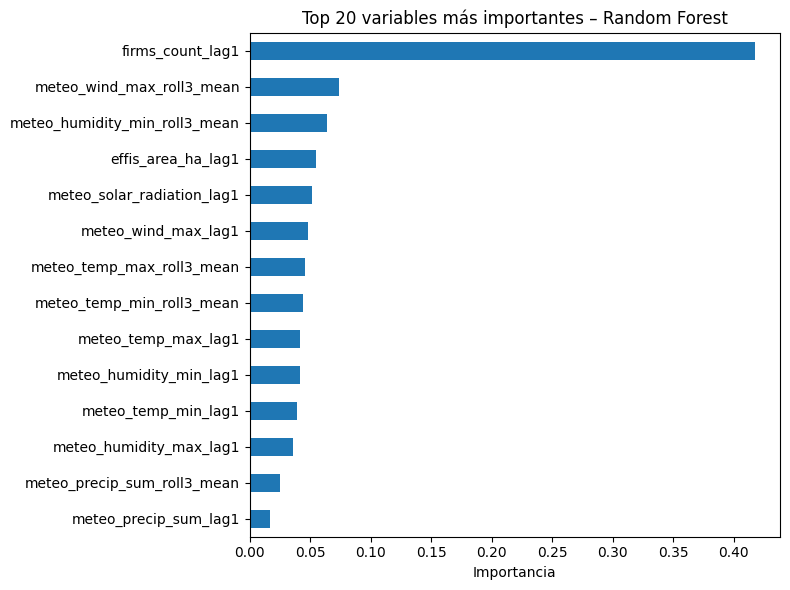


✅ Modelo guardado en: C:\Users\aitor.herran\Desktop\incendios\modelo_rf_riesgo_provincia_dia.joblib
✅ Threshold guardado en: C:\Users\aitor.herran\Desktop\incendios\modelo_rf_riesgo_threshold.npy


In [ ]:
# ============================================================
# 02_modelado_ml.ipynb
# Modelado de riesgo provincia–día (clasificación binaria)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
)

import joblib

# ---------------------------------------------
# 1. Carga de dataset ML
# ---------------------------------------------
DATA_DIR = r"C:\Users\aitor.herran\Desktop\incendios"
DATASET_ML_PATH = os.path.join(DATA_DIR, "dataset_ml_prov_daily.csv")

df = pd.read_csv(DATASET_ML_PATH, parse_dates=["date"])
df["provincia"] = df["provincia"].astype(str).str.strip()

print("Shape dataset ML:", df.shape)
print("Columnas:", df.columns.tolist()[:20])

target = "y_riesgo_alto"
feature_cols = [c for c in df.columns if c.endswith("_lag1") or c.endswith("_roll3_mean")]

print("\nNúmero de features:", len(feature_cols))
print("Ejemplo features:", feature_cols[:10])

X = df[feature_cols]
y = df[target]

# ---------------------------------------------
# 2. Split temporal train / test
#    Train: hasta 2021 incluido
#    Test:  2022 en adelante
# ---------------------------------------------
df["year"] = df["date"].dt.year

print("\nAños disponibles:", sorted(df["year"].unique().tolist()))
print("Positivos por año:")
print(df.groupby("year")[target].sum())

year_split = 2021
train_mask = df["year"] <= year_split
test_mask  = df["year"] > year_split

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

print("\nShape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)

print("\nDistribución clases en train:")
print(y_train.value_counts())
print("\nDistribución clases en test:")
print(y_test.value_counts())

# ---------------------------------------------
# 3. Baseline: modelo que siempre predice 0
# ---------------------------------------------
print("\n===== BASELINE (predice siempre clase 0) =====")
y_pred_base = np.zeros_like(y_test)

print(classification_report(y_test, y_pred_base, digits=3))
print("Matriz de confusión baseline:")
print(confusion_matrix(y_test, y_pred_base))

# ---------------------------------------------
# 4. Random Forest: entrenamiento con class_weight=balanced
# ---------------------------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42,
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\n===== RANDOM FOREST (threshold 0.50) =====")
print(classification_report(y_test, y_pred, digits=3))
print("Matriz de confusión RF (0.5):")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", auc)

# ---------------------------------------------
# 5. Tuning de threshold (precision-recall / F1)
# ---------------------------------------------
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

pr_df = pd.DataFrame({
    "threshold": np.append(thresholds, [1.0]),
    "precision": precisions,
    "recall": recalls,
})
pr_df["f1"] = 2 * (pr_df["precision"] * pr_df["recall"]) / (
    pr_df["precision"] + pr_df["recall"] + 1e-9
)

# Elegimos el threshold que maximiza F1
best_row = pr_df.iloc[pr_df["f1"].idxmax()]
best_thr = float(best_row["threshold"])

print("\n===== TUNING DE THRESHOLD =====")
print("Mejor threshold según F1:", best_thr)
print("Fila correspondiente:")
print(best_row)

# Evaluación con threshold optimizado
y_pred_thr = (y_proba >= best_thr).astype(int)

print("\n===== RANDOM FOREST (threshold optimizado) =====")
print(classification_report(y_test, y_pred_thr, digits=3))
print("Matriz de confusión RF (threshold optimizado):")
print(confusion_matrix(y_test, y_pred_thr))

# ---------------------------------------------
# 6. Importancia de variables
# ---------------------------------------------
importances = pd.Series(rf.feature_importances_, index=feature_cols)
imp_top = importances.sort_values(ascending=False).head(20)

print("\nTop 20 variables más importantes:")
print(imp_top)

plt.figure(figsize=(8, 6))
imp_top.sort_values().plot(kind="barh")
plt.title("Top 20 variables más importantes – Random Forest")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 7. Guardar modelo y threshold
# ---------------------------------------------
MODEL_PATH = os.path.join(DATA_DIR, "modelo_rf_riesgo_provincia_dia.joblib")
THR_PATH   = os.path.join(DATA_DIR, "modelo_rf_riesgo_threshold.npy")

joblib.dump(rf, MODEL_PATH)
np.save(THR_PATH, np.array([best_thr]))

print("\n✅ Modelo guardado en:", MODEL_PATH)
print("✅ Threshold guardado en:", THR_PATH)


